# Covid19 - Exploratory data analysis
**Table of contents:**
* Importing dependecies
* Basic data manipulation - grouping, aggregating etc.
* Model building
    * ARIMA
    * Linear Regression
    * Prophet

In [1]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
import datetime

warnings.filterwarnings('ignore')

In [2]:
# Getting all the files in "data" directory 
list_of_files = os.walk('./data/')
list_of_files = list(list_of_files)[0][2]

# For EDA purposes I am going to use only one country as a template
DIR = './data/'
COUNTRY = 'poland.csv'

In [3]:
dataset = pd.read_csv(DIR + COUNTRY)

In [4]:
dataset.head()

,Unnamed: 0,Date,Cases
0,0,2020-03-04,1
1,1,2020-03-05,1
2,2,2020-03-06,5
3,3,2020-03-07,5
4,4,2020-03-08,11


In [5]:
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
dataset['Date'] = pd.to_datetime(dataset['Date'])

I am interested in prediciting not only *total cases* but also **new cases**, however dataset only contains *total cases* for each day. Luckly this provides enough information to **new cases**. We know that new cases is just the difference between day **n+1** and **n**. We can use a formula: ***NewCases*** = **TotalCases(n+1)** - **TotalCases(n)**. For the last row in the dataset NewCases is going to be undefined, becouse we don't have **TotalCases(n+1).**

In [6]:
# this loop implements formula from above
new_cases = []
for n in range(dataset.shape[0]):
    try:
        new_cases.append(dataset['Cases'][n+1] - dataset['Cases'][n])
    except KeyError:
        # new_cases.append(np.NaN) - would contain nan, so let's just pass
        pass

In [7]:
# Now let's drop last row becouse it contains a NaN
dataset.drop(dataset.tail(1).index, inplace=True)

In [8]:
dataset['New_cases'] = new_cases
dataset = dataset.rename(columns={'Cases' : 'Cummulative_cases'})
dataset.head()

,Date,Cummulative_cases,New_cases
0,2020-03-04,1,0
1,2020-03-05,1,4
2,2020-03-06,5,0
3,2020-03-07,5,6
4,2020-03-08,11,5


At the moment *date* column has a frequency of one day - in practice when we look at time series data we should be more concerned with *longer* periods of time such as weeks or months if not years in some cases. **Pandas** *groupby* is ideal for such case.

In [9]:
dataset = dataset.groupby(pd.Grouper(key='Date',freq='W-MON')).agg({'Cummulative_cases':'sum', 'New_cases':'sum'})
dataset = dataset.reset_index()
dataset.head()

,Date,Cummulative_cases,New_cases
0,2020-03-09,39,21
1,2020-03-16,569,216
2,2020-03-23,3188,663
3,2020-03-30,10117,1410
4,2020-04-06,23336,2537


In [10]:
# Spliting into two DataFrames
new_cases, cummulative_cases = dataset[['New_cases', 'Date']], dataset[['Cummulative_cases', 'Date']]
# Let index be data
new_cases = new_cases.set_index('Date')
cummulative_cases = cummulative_cases.set_index('Date')

new_cases.head()

,New_cases
Date,
2020-03-09,21
2020-03-16,216
2020-03-23,663
2020-03-30,1410
2020-04-06,2537


**Now our data in nicely organized :)**

**Let's move on to data visualiaztion.**

In [11]:
def plot(data_1, data_2, save=False):
    # Function to plot both cummulative cases and new cases
    fig, ax = plt.subplots(2, 1, figsize=(12,12))

    ax[0].plot(data_1, marker='o', color='red')
    ax[0].set_title('{} cases'.format(data_1.columns[0]))
    ax[1].plot(data_2, marker='o', color='red')
    ax[1].set_title('{} cases'.format(data_2.columns[0]))

    for i in range(2):
        for k in ['top', 'right']:
            ax[i].spines[k].set_visible(False)

        ax[i].spines['left'].set_color('black')
        ax[i].spines['bottom'].set_color('black')

        ax[i].grid(axis='y', linestyle='dashed')
        ax[i].xaxis.grid(False)
        
    if save:
        plt.savefig('sample_chart.jpg')
        
    plt.show()

**Forecasting time series**

While forecasting time series, there is one very important prerequisites, before fitting to a statistical model - **stationarity.**

**Stationarity** - Data is stationary when it's statistical properties (mean, standard deviation, variance) don't change over time. Good non-statistical method of testing statinarity is plotting and just looking and at **trend** and **seasonality.**

* **Trend** - long term tendency to increase or decrease (increasing sales over few years)
* **Seasonality** - short term tendency to increase or decrease (increasing sales during christmas)

**Knowing this let's plot the data**

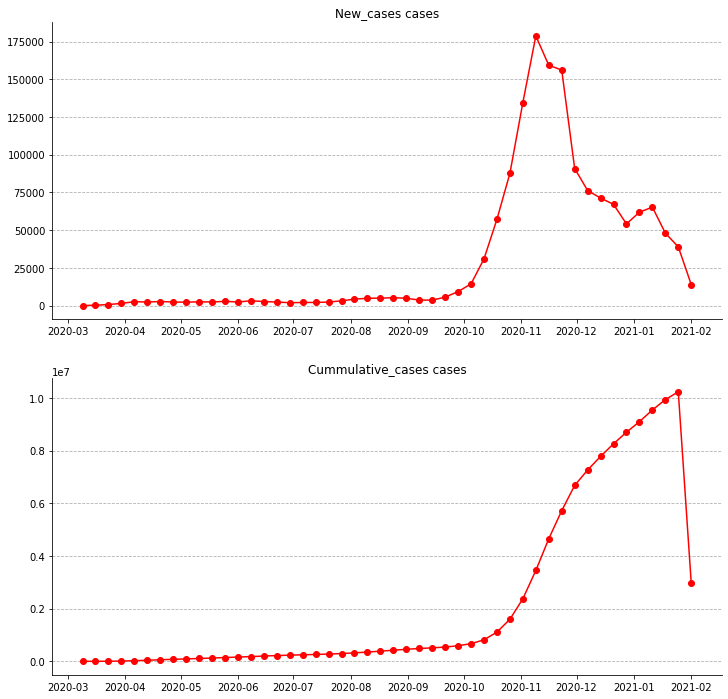

In [12]:
plot(new_cases, cummulative_cases)

**Cummulative cases** - Clear increasing trend, no visible seasonality.<br>
**New cases** - Hard to tell visually but I belive that from 2020-10 to 2021-02 is seasonal increase becouse during winter it is easier to get sick.<br>
**Statsmodels** provides a way to decompose data and plot trend and seasonality separately<br>

**NOTE: Next few lines do not cover cummulative cases, becouse I am going to forecast it with Linear Regression, and these next lines are ARIMA specifc.**

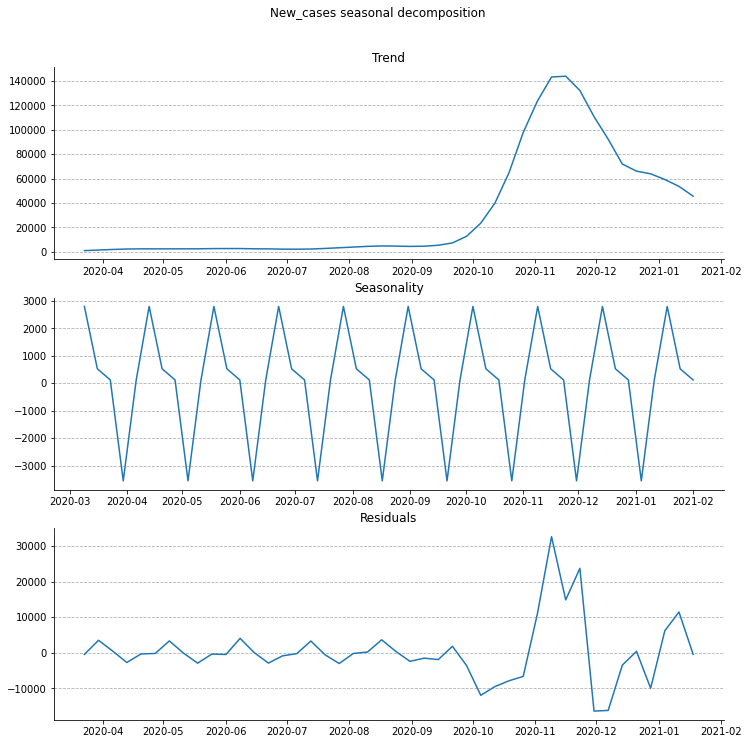

In [13]:
def decompose(data, save=False):
    # Using seasonal_decompose from statsmodels 
    decomposition = seasonal_decompose(data, period=5)
    trend = decomposition.trend
    seasonality = decomposition.seasonal
    residual = decomposition.resid
    # Plotting
    fig, ax = plt.subplots(3, 1, figsize=(12,12))
    ax[0].plot(trend)
    ax[0].set_title('Trend')
    ax[1].plot(seasonality)
    ax[1].set_title('Seasonality')
    ax[2].plot(residual)
    ax[2].set_title('Residuals')
    for i in range(3):
        for k in ['top', 'right']:
            ax[i].spines[k].set_visible(False)

        ax[i].spines['left'].set_color('black')
        ax[i].spines['bottom'].set_color('black')

        ax[i].grid(axis='y', linestyle='dashed')
        ax[i].xaxis.grid(False)
    fig.suptitle('{} seasonal decomposition'.format(data.columns[0]), y=0.95)
    if save:
        plt.savefig('seasonal.jpg')
    plt.show()
    
decompose(new_cases)

**Now trend and seasonality are clearly visible.**<br>
In order to mathematicaly confirm what our visualizations are implying we can use **Dickey-Fuller test.**<br>
**Dickey-Fuller test** is probadly the most common statistical approach to test data stationarity.

Results:
Test Statistic                 -1.787739
p-value                         0.386566
#Lags Used                      3.000000
Number of Observations Used    44.000000
dtype: float64
Critical value 1% 	 -3.5885733964124715
Critical value 5% 	 -2.929885661157025
Critical value 10% 	 -2.6031845661157025
Critical values are < Test Statistic


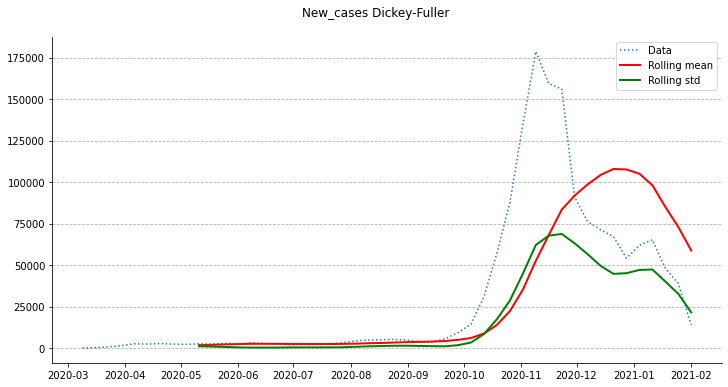

In [14]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(data, save=False):
    # Rolling mean and standard deviation
    rolling_mean = data.rolling(window=10).mean()
    rolling_std = data.rolling(window=10).std()
    # Dickey-fuller test
    print('Results:')
    test = adfuller(data)
    result = pd.Series(test[0:4], index=['Test Statistic', 
                                         'p-value', 
                                         '#Lags Used', 
                                         'Number of Observations Used'])
    print(result)
    for k,v in test[4].items():
        print('Critical value {} \t {}'.format(k, v))
        if result.loc['Test Statistic'] < v:
            print('Critical valies {} > Test Statistic'.format(k))
            break
    else:
        print('Critical values are < Test Statistic')
    #Plotting
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    plt.plot(data, ':', label='Data')
    plt.plot(rolling_mean, 'r', linewidth=2, label="Rolling mean")
    plt.plot(rolling_std, 'g', linewidth=2, label="Rolling std")
    for k in ['top', 'right']:
        ax.spines[k].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
    ax.grid(axis='y', linestyle='dashed')
    ax.xaxis.grid(False)
    ax.legend()
    fig.suptitle('{} Dickey-Fuller'.format(data.columns[0]), y=0.95)
    if save:
        plt.savefig('roll.jpg')
    plt.show()
    
dickey_fuller(new_cases)

**In the second case critical values are < Test Statistic and in both cases rolling mean and rolling std are increasing, so data isn't stationary.**<br> 
To make data stationary we have to make sure that:
* Mean dosn't change over time (there are no trend)
* Std dosn't change over time(there is no seasonality)<br>

**Let's start by de-trending.** We can use a few methods:<br>

* Differnciation
* Taking a Log, Sqrt, Cube etc.
* Applying exponential decay

**Becouse Covid19 data is basically and exponential funtion I am going to take log**

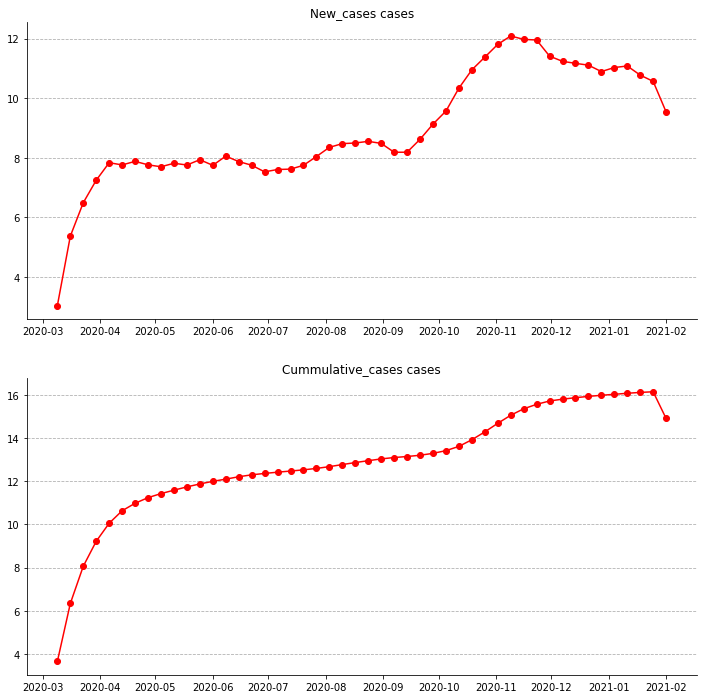

In [15]:
plot(np.log(new_cases), np.log(cummulative_cases))

**I know I said that next few lines aren't going to include cummulative cases, but since Linear Regression is going to work for that case only if data is in log scale, I though I might aswell plot it in one function.**

Results:
Test Statistic                 -1.223221
p-value                         0.663528
#Lags Used                      2.000000
Number of Observations Used    45.000000
dtype: float64
Critical value 1% 	 -3.584828853223594
Critical value 5% 	 -2.9282991495198907
Critical value 10% 	 -2.6023438271604937
Critical values are < Test Statistic


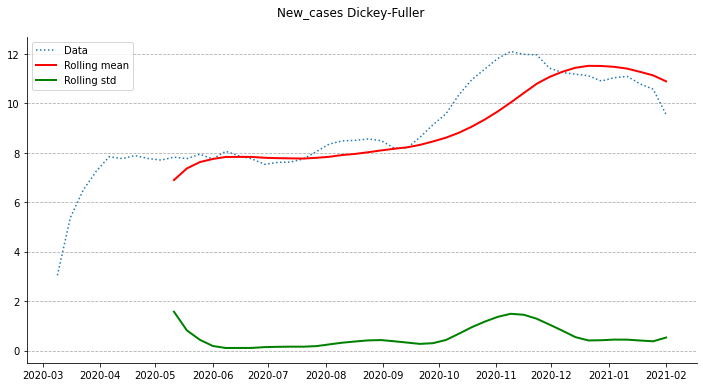

In [16]:
dickey_fuller(np.log(new_cases))

**Seems like taking log of original data helped to stationarize new cases.**

In [17]:
new_log = np.log(new_cases)
# cummulative cases have to be in log scale aswell
cummulative_log = np.log(cummulative_cases)

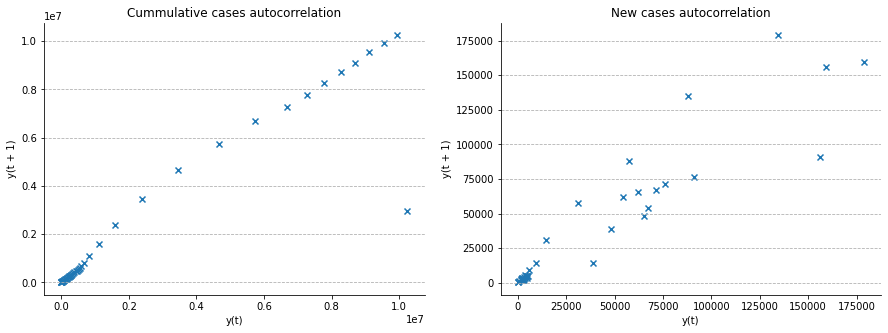

In [18]:
def autocorr(new, cummulative, save=False):
    figure, ax = plt.subplots(1, 2, figsize=(15,5))

    lag_plot(cummulative, ax=ax[0], marker='x')
    ax[0].set_title('Cummulative cases autocorrelation')
    lag_plot(new, ax=ax[1], marker='x')
    ax[1].set_title('New cases autocorrelation')

    for i in range(2):
        for k in ['top', 'right']:
            ax[i].spines[k].set_visible(False)

        ax[i].spines['left'].set_color('black')
        ax[i].spines['bottom'].set_color('black')

        ax[i].grid(axis='y', linestyle='dashed')
        ax[i].xaxis.grid(False)
    if save:
        plt.savefig('autocorr.jpg')
    plt.show()
    
autocorr(new_cases, cummulative_cases)

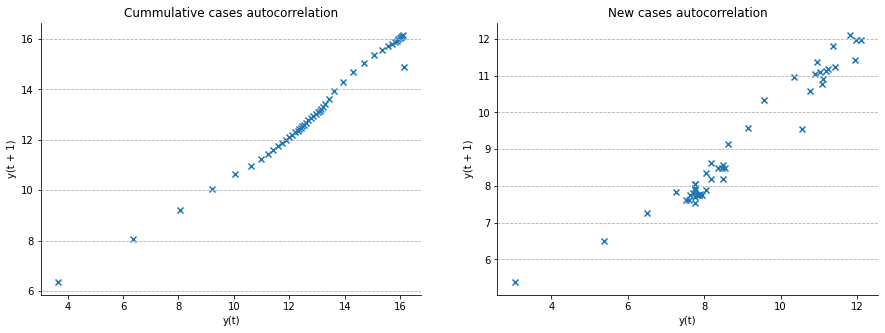

In [19]:
autocorr(new_log, cummulative_log)

**After taking log data became much more linear correlated so the models should do a better job :)**<br>

In [20]:
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_true.shape[0] != y_pred.shape[0]:
        raise Exception('Vectors have different dimiensions y_pred{} y_true{}'.format(y_true.shape, y_pred.shape))
    else:
        return np.sqrt(np.sum(np.square(y_pred - y_true))/y_true.shape[0])

# ARIMA modeling

**ARIMA** stands for:
* **AR** - Auto regressive - these types of models assume that previous values impact current ones. Formula for auto regressive model : <p align='center'><div>$y_{t}=B_{1}y_{t-1}+B_{2}y_{t-2}+...+B_{n}y_{t-n}$</div></p>
* **I** - Integrated - It basically means that we we add diferencing to the model, thus stationarizing it. 
* **MA** - Moving average - assumes that current value of $y$ is influenced by previous days term error. Formula : <p align='center'><div>$y_{t}=\mu + \epsilon + \theta_{1}\epsilon_{t-1}+...+\theta_{n}\epsilon_{t-n}$</div></p>

**ARMA** = **AR** + **MA**.<br>
**ARIMA** = **ARMA** + diferenciating.<br>

**ARIMA** has 3 parameters:
* $p$ - number of auto regressive terms
* $d$ - number of diferences 
* $q$ - number of moving average terms

**This means that we can choose which model to use - AR, MA, or combination of both**

**In order to find $p$ and $q$ parameters we plot *Autocorrelation function* (ACF) and *Partial Autocorrelation function* (PACF)**
* ACF - Is the meassure of correlation between time series and past values of the time series. If ACF is positive at lag 1 then we use AR model else MA.
* PACF - If curve drops very drastically, use AR else MA

**Now let's use statsmodels to find ACF and PACF and plot them!**

In [21]:
from statsmodels.tsa.stattools import acf, pacf

def corr_functions(data, save=False): 
    # ACF and PACF
    ACF = acf(data, nlags=22)
    PACF = pacf(data, nlags=22, method='ols')
    # Plotting
    title = str(data.columns[0])
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].plot(ACF, linewidth=2)
    ax[0].set_title('ACF {}'.format(title))
    ax[1].plot(PACF, linewidth=2)
    ax[1].set_title('PACF {}'.format(title))
    for i in range(2):
        for k in ['top', 'right']:
            ax[i].spines[k].set_visible(False)

        ax[i].spines['left'].set_color('black')
        ax[i].spines['bottom'].set_color('black')

        ax[i].grid(axis='y', linestyle='dashed')
        ax[i].xaxis.grid(False)
    if save:
        plt.savefig('corr.jpg')
    plt.show()

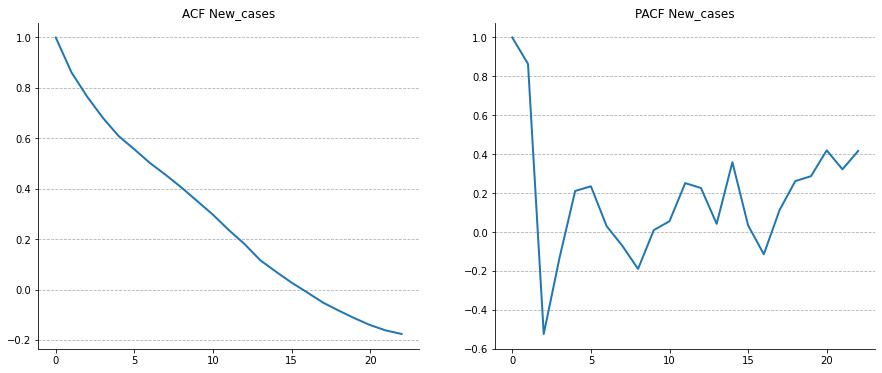

In [22]:
corr_functions(new_log)

**ACF gradually descends towards 0, PACF sharply drops - signs to use AR model** Just for caution I am going to try AR, MA, and both - just to be sure.

In [23]:
def model_graph(data, save=False):
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))
    # Loop for each model
    for i, param in enumerate(['AR', 'MA', None]):
        if param == 'AR':
            model = ARIMA(data, order=(2,1,0))
        elif param == "MA":
            model = ARIMA(data, order=(0,1,2))
        else:
            model = ARIMA(data, order=(2,1,2))
        results = model.fit(disp=-1)
        # Forecast plot
        results.plot_predict(1, 60, ax=ax[i])
        for k in ['top', 'right']:
            ax[i].spines[k].set_visible(False)

        ax[i].spines['left'].set_color('black')
        ax[i].spines['bottom'].set_color('black')

        ax[i].grid(axis='y', linestyle='dashed')
        ax[i].xaxis.grid(False)
        title = lambda x : str(x) if param else 'ARIMA'
        ax[i].set_title(title(param))
    if save:
        plt.savefig('autocorr.jpg')
    plt.show()

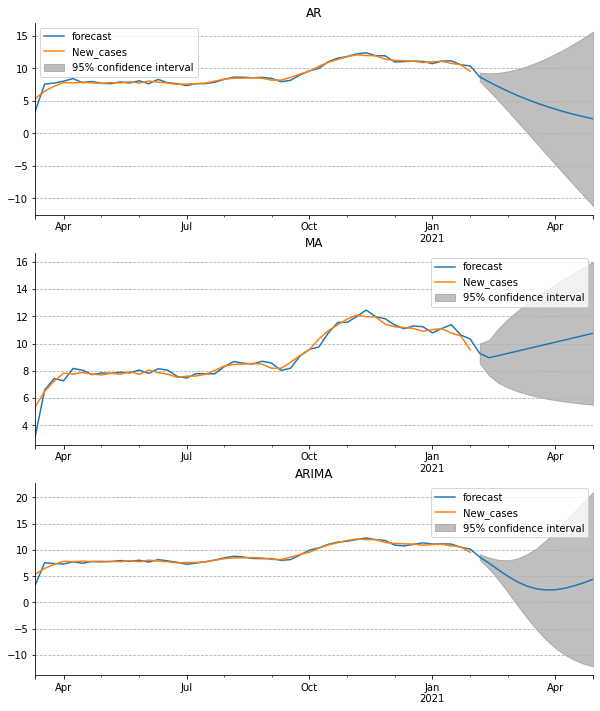

In [24]:
model_graph(new_log)

**Becouse cummulative cases has much smoother curve than new cases applying log transform and using simple linear regression might be better than ARIMA. I'll try that in a moment, but first let's evaluate ARIMA's performance on new cases!**

In [25]:
def arima(data, fit_data, future, save=False):
    # Fit the model and predict
    model = ARIMA(data, order=(2,1,2))
    model = model.fit()
    preds = model.predict(start=1, end=future, typ='levels')
    print('RMSE : {}'.format(rmse(np.exp(preds)[:fit_data.shape[0]], fit_data)))
    # Plot results
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    ax.plot(np.exp(preds), linewidth=1.5, label='Forecast')
    ax.plot(fit_data, '--', linewidth=2, label='Data')
    for k in ['top', 'right']:
        ax.spines[k].set_visible(False)

    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    ax.grid(axis='y', linestyle='dashed')
    ax.xaxis.grid(False)
    plt.legend()
    if save:
        plt.savefig('autocorr.jpg')
    plt.show()
    
    # This is very bad practice, but i have no other idea how to get linear regression to predict cummulative cases
    global dates_for_lin_reg
    dates_for_lin_reg = preds.index[len(fit_data):len(preds)]

RMSE : 475941.9659317978


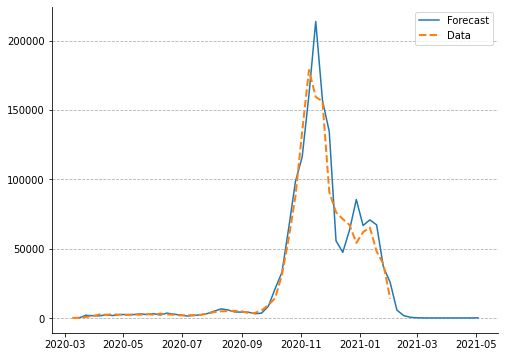

In [26]:
arima(new_log, new_cases, len(new_log)+12)

# Linear Regression
**Linear Regression is probadly the simplest algorithm in machine learning - one that everyone learns. It works on a simple linear equation:** $h(x) = \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n}x_{n}$ with MSE loss function $MSE = \frac{1}{m}\sum\limits_{i=1}^{m}(y_{i} - \hat{y_{i}})^2$ and SGD optimizer. It is very simple, but that is why it works, I like to use it becouse I know it very well, it is easy to implement and understand and works for a lot of cases.

In [31]:
def linear_regression(data, dates_to_predict):
    # Statsmodels implementation of linear regression
    # Converting dates to ordinal
    idx = pd.to_datetime(data.index)
    idx = [datetime.datetime.toordinal(date) for date in list(idx)]
    # Fitting the model
    lin_reg = sm.OLS(list(data.values), list(idx))
    res = lin_reg.fit()
    # Converting dates to predict to ordinal
    dates_to_predict = pd.to_datetime(dates_to_predict)
    dates_to_predict = [datetime.datetime.toordinal(date) for date in list(dates_to_predict)]
    # Predicting
    preds = res.predict(np.squeeze(np.asarray(dates_to_predict)))
    # Back to date
    DATES = [datetime.datetime.fromordinal(date) for date in list(dates_to_predict)]
    # Results into series
    cummulative_series = pd.Series(data=np.exp(preds), index=DATES)
    return cummulative_series

In [32]:
linear_regression(cummulative_log, dates_for_lin_reg)

2021-02-15    402290.941078
2021-02-22    402340.197257
2021-03-01    402389.459466
2021-03-08    402438.727708
2021-03-15    402488.001982
2021-03-22    402537.282289
2021-03-29    402586.568630
2021-04-05    402635.861005
2021-04-12    402685.159416
2021-04-19    402734.463863
2021-04-26    402783.774347
2021-05-03    402833.090868
dtype: float64

# Prophet modeling

**Prophet is an open-source package for time series modeling from Facebook Data Science team. It's written in Stan so it's lighting fast :). Prophet uses hypothesis** $y(t) = g(t) + s(t) + h(t) + \epsilon(t)$ where:
* $g(t)$ - Linear or logistic curve for data modeling.
* $s(t)$ - Seasonality, prophet uses yearly, weekly and daily seasonality.
* $h(t)$ - Holidays effect.
* $\epsilon(t)$ - Error term, in case of any unusual data.

**Becouse of $s(t)$ Prophet takes care of seasonality for us! We just have to plug in the data and run the model!**

In [61]:
from fbprophet import Prophet

def prophet_forecast(data, periods):
    # Prophet requires to use special DataFrame template
    p_data = data.reset_index()
    cols = p_data.columns
    p_data = p_data.rename(columns={cols[0] : 'ds', cols[1] : 'y'})
    # Instanciating Prophet class
    prophet = Prophet(yearly_seasonality=True, uncertainty_samples=False, changepoint_prior_scale=2, interval_width=0.95)
    prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
    prophet.fit(p_data)
    future = prophet.make_future_dataframe(periods=periods)
    forecast = prophet.predict(future)
    fig1 = prophet.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


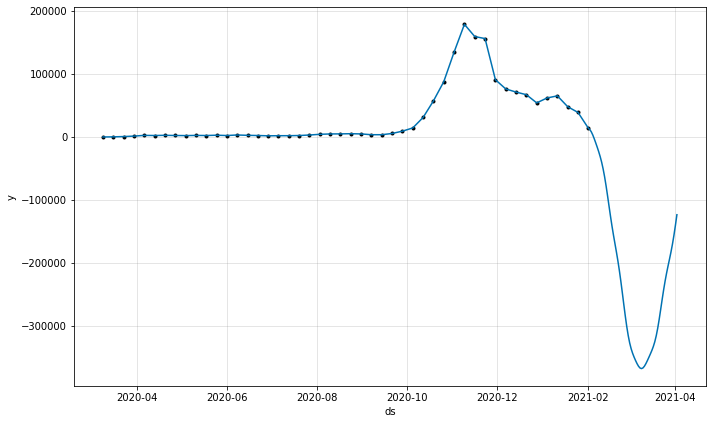

In [62]:
prophet_forecast(new_cases, 60)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


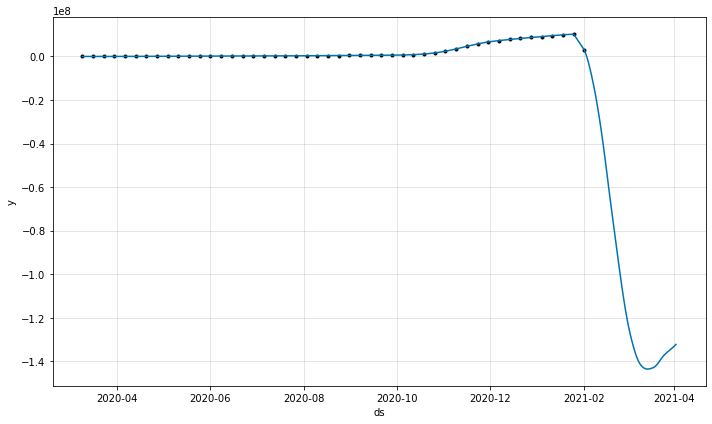

In [63]:
prophet_forecast(cummulative_cases, 60)

**Now onto the website!**